## Scraping Data

Obtaining the download links to the LMIA datasets of the latest years . 

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


url = 'https://open.canada.ca/data/en/dataset/90fed587-1364-4f33-a9ee-208181dc0b97'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
 
urls = []
for link in soup.find_all(string=re.compile("pos_en.xlsx")):
    urls.append(link)
print(urls)


['https://open.canada.ca/data/dataset/90fed587-1364-4f33-a9ee-208181dc0b97/resource/cff0477d-8ab1-4252-b56a-2cd96b057049/download/tfwp_2022q4_pos_en.xlsx', 'https://open.canada.ca/data/dataset/90fed587-1364-4f33-a9ee-208181dc0b97/resource/65794992-cce4-4103-a1f6-ec6e3d249e90/download/tfwp_2023q1_pos_en.xlsx', 'https://open.canada.ca/data/dataset/90fed587-1364-4f33-a9ee-208181dc0b97/resource/aed9328a-1b42-48bd-a096-75ef06eba025/download/tfwp_2023q2_pos_en.xlsx', 'https://open.canada.ca/data/dataset/90fed587-1364-4f33-a9ee-208181dc0b97/resource/d48a4d9a-fffa-4c02-81c9-93332c52f2df/download/tfwp_2023q3_pos_en.xlsx', 'https://open.canada.ca/data/dataset/90fed587-1364-4f33-a9ee-208181dc0b97/resource/aa0a56e3-244e-4958-8f60-82e5b478bebe/download/tfwp_2023q4_pos_en.xlsx', 'https://open.canada.ca/data/dataset/90fed587-1364-4f33-a9ee-208181dc0b97/resource/049928ce-0e7f-480b-9983-f5fa46f612ae/download/tfwp_2024q1_pos_en.xlsx']


Downloading the datasets 

In [17]:


# Directory to save the downloaded files
download_directory = "downloaded_files"

# Create the directory if it doesn't exist
os.makedirs(download_directory, exist_ok=True)

# Function to download a file from a URL and save it locally
def download_file(url, directory):
    # Get the filename from the URL
    filename = url.split("/")[-1]
    # Full path to save the file
    file_path = os.path.join(directory, filename)
    
    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # Check for request errors

    # Write the content to a file
    with open(file_path, "wb") as file:
        file.write(response.content)
    print(f"Downloaded {filename}")

# Loop through each URL and download the file
for url in urls:
    download_file(url, download_directory)
    

Downloaded tfwp_2022q4_pos_en.xlsx
Downloaded tfwp_2023q1_pos_en.xlsx
Downloaded tfwp_2023q2_pos_en.xlsx
Downloaded tfwp_2023q3_pos_en.xlsx
Downloaded tfwp_2023q4_pos_en.xlsx
Downloaded tfwp_2024q1_pos_en.xlsx


Combining the datasets into one


In [59]:
# List to hold each DataFrame
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(download_directory):
    if filename.endswith(".xlsx"):
        file_path = os.path.join(download_directory, filename)
        # Read the Excel file into a DataFrame
        df = pd.read_excel(file_path, skiprows=1, skipfooter=8)
        # Standardize column names by stripping leading/trailing spaces and converting to lowercase
        df.columns = df.columns.str.strip().str.lower()
        dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined DataFrame to a new Excel file
combined_df.to_excel("combined_data.xlsx", index=False)

In [60]:
combined_df.head()

,province/territory,program stream,employer,address,occupation,incorporate status,approved lmias,approved positions
0,Newfoundland and Labrador,High Wage,85242 Newfoundland and Labrador Inc.,"Spaniard's Bay, NL A0A 3X0","7204-Contractors and supervisors, carpentry tr...",Unknown,1.0,1.0
1,Newfoundland and Labrador,High Wage,85242 Newfoundland and Labrador Inc.,"Spaniard's Bay, NL A0A 3X0",7251-Plumbers,Unknown,1.0,2.0
2,Newfoundland and Labrador,High Wage,Blanchard's Heating & Cooling Ltd.,"Corner Brook, NL A2H 4C4",7313-Refrigeration and air conditioning mechanics,Unknown,1.0,1.0
3,Newfoundland and Labrador,High Wage,Christopher's Trucking,"Forteau, NL A0K 2P0",7511-Transport truck drivers,Unknown,1.0,2.0
4,Newfoundland and Labrador,High Wage,Grieg Seafarms NL Ltd.,"St Alban's, NL A0H 2E0",0823-Managers in aquaculture,Unknown,2.0,2.0


## Cleaning data

Removing companies from Quebec from the data (Language barrier)

In [61]:
# Remove rows where the 'province' column is 'Quebec'
combined_df = combined_df[combined_df['province/territory'] != 'Quebec']


Filtering companies that hired Mathematicians, statisticians, actuaries, computer and information systems professionals.


In [62]:
combined_df = combined_df[combined_df["occupation"].astype(str).str.startswith(('216', '217'))]

Grouping by employer and summing the number of approved lmias obtaining the total lmias approved by employer.

In [45]:
# Perform group by, sum, and sort
grouped_df = combined_df.groupby("employer")["approved lmias"].sum().reset_index()
sorted_df = grouped_df.sort_values(by="approved lmias", ascending=False)


## Plotting the top hiring companies

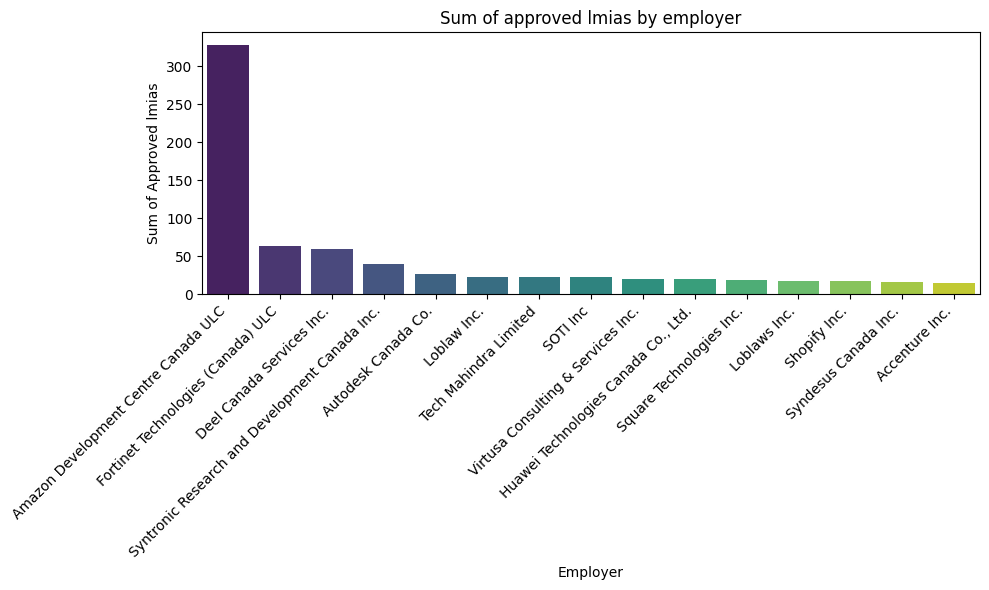

In [57]:

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="employer", y="approved lmias", data=sorted_df.head(15), palette="viridis", hue="employer")
plt.xticks(rotation=45, ha='right')
plt.title(f'Sum of {"approved lmias"} by {"employer"}')
plt.xlabel("employer".capitalize())
plt.ylabel(f'Sum of {"approved lmias".capitalize()}')
plt.tight_layout()
